# Project: NLP for Cleantech
### Stage 2: Training Word and Sentence Embedding Models
Authors: Esin, Sabrina

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
import gensim
import tensorflow as tf
import spacy
import pickle
from spacy.cli.download import download
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import string
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim import corpora

In [ ]:
!pip install glove-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.0/327.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for glove-python3: filename=glove_python3-0.1.0-cp310-cp310-linux_x86_64.whl size=1065505 sha256=b77f81ff361f4ae37d7629f2bd7becb8ac2b3a1da98b27bba1f3601d5d7210f1
  Stored in directory: /root/.cache/pip/wheels/fe/2f/79/34314d44a0907e90e323c8c182ec23f126eb460829e02d98cf
Successfully built glove-python3


In [ ]:
from glove import Corpus, Glove

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. Data Preparation for Embeddings

In [ ]:
import pandas as pd
cleantech = pd.read_csv("/content/drive/MyDrive/CLT Project/NLP Stage 1/cleantech_media_dataset_v1_20231109.csv",delimiter=",",low_memory=False)
cleantech

Unnamed: 0                                              title  \
0           1280  Qatar to Slash Emissions as LNG Expansion Adva...   
1           1281               India Launches Its First 700 MW PHWR   
2           1283              New Chapter for US-China Energy Trade   
3           1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...   
4           1285     NYC Pension Funds to Divest Fossil Fuel Shares   
...          ...                                                ...   
9602       82339  Strata Clean Energy Nets $ 300 Million in Fund...   
9603       82340  Orsted Deploying SparkCognition Renewable Suit...   
9604       82341     Veolia Has Plans for 5 MW of Solar in Arkansas   
9605       82342                      SunEdison: Too Big, Too Fast?   
9606       82343  Vikings Solar-Plus-Storage Development Nets Fi...   

            date author                                            content  \
0     2021-01-13    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...   
1     2021-01-15    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...   
2     2021-01-20    NaN  ["New US President Joe Biden took office this ...   
3     2021-01-22    NaN  ["The slow pace of Japanese reactor restarts c...   
4     2021-01-25    NaN  ["Two of New York City's largest pension funds...   
...          ...    ...                                                ...   
9602  2023-11-06    NaN  ['Strata Clean Energy has closed a $ 300 milli...   
9603  2023-11-07    NaN  ['Global renewable energy developer Ørsted is ...   
9604  2023-11-07    NaN  ['Veolia North America, a provider of environm...   
9605  2023-11-08    NaN  ['Once the self-proclaimed “ leading renewable...   
9606  2023-11-08    NaN  ['Arevon Energy Inc. has closed financing on t...   

                domain                                                url  
0          energyintel  https://www.energyintel.com/0000017b-a7dc-de4c...  
1          energyintel  https://www.energyintel.com/0000017b-a7dc-de4c...  
2          energyintel  https://www.energyintel.com/0000017b-a7dc-de4c...  
3          energyintel  https://www.energyintel.com/0000017b-a7dc-de4c...  
4          energyintel  https://www.energyintel.com/0000017b-a7dc-de4c...  
...                ...                                                ...  
9602  solarindustrymag  https://solarindustrymag.com/strata-clean-ener...  
9603  solarindustrymag  https://solarindustrymag.com/orsted-deploying-...  
9604  solarindustrymag  https://solarindustrymag.com/veolia-has-plans-...  
9605  solarindustrymag  http://www.solarindustrymag.com/online/issues/...  
9606  solarindustrymag  https://solarindustrymag.com/vikings-solar-plu...  

[9607 rows x 7 columns]

In [ ]:
#Rename "Unnamed: 0 " column for better accessibility:
cleantech.rename(columns={'Unnamed: 0':'rowID'}, inplace=True)

##### 1.1 Clean-Up Data

In [ ]:
dupl_title = cleantech[cleantech.duplicated(subset=["title"],keep=False)]

In [ ]:
dupl_content = cleantech[cleantech.duplicated(subset=["content"],keep=False)]

In [ ]:
#Extract all rows to be removed in dupl title:
contain_sgvoice_dupltitle = dupl_title[dupl_title['url'].str.contains('sgvoice')]
#print(contain_sgvoice_dupltitle)

#Delete the rows in contain_sgvoice_dupltitle from cleantech:
list1 = contain_sgvoice_dupltitle["rowID"].values.tolist()
cleantech_nodupl = cleantech[cleantech.rowID.isin(list1) == False]

In [ ]:
#Delete all articles with duplicate content:
cleantech_nodupl = cleantech_nodupl.drop_duplicates(subset='content')

#Extract useful columns:
cleantech_con = cleantech_nodupl[["title", "content"]]

#Concatenate title and content:
cleantech_con['text'] = cleantech_con['title'] + ' ' + cleantech_con['content']

cleantech_con.reset_index(drop=True)

<ipython-input-8-7a7056a23e08>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleantech_con['text'] = cleantech_con['title'] + ' ' + cleantech_con['content']


title  \
0     Qatar to Slash Emissions as LNG Expansion Adva...   
1                  India Launches Its First 700 MW PHWR   
2                 New Chapter for US-China Energy Trade   
3     Japan: Slow Restarts Cast Doubt on 2030 Energy...   
4        NYC Pension Funds to Divest Fossil Fuel Shares   
...                                                 ...   
9585  Strata Clean Energy Nets $ 300 Million in Fund...   
9586  Orsted Deploying SparkCognition Renewable Suit...   
9587     Veolia Has Plans for 5 MW of Solar in Arkansas   
9588                      SunEdison: Too Big, Too Fast?   
9589  Vikings Solar-Plus-Storage Development Nets Fi...   

                                                content  \
0     ["Qatar Petroleum ( QP) is targeting aggressiv...   
1     ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...   
2     ["New US President Joe Biden took office this ...   
3     ["The slow pace of Japanese reactor restarts c...   
4     ["Two of New York City's largest pension funds...   
...                                                 ...   
9585  ['Strata Clean Energy has closed a $ 300 milli...   
9586  ['Global renewable energy developer Ørsted is ...   
9587  ['Veolia North America, a provider of environm...   
9588  ['Once the self-proclaimed “ leading renewable...   
9589  ['Arevon Energy Inc. has closed financing on t...   

                                                   text  
0     Qatar to Slash Emissions as LNG Expansion Adva...  
1     India Launches Its First 700 MW PHWR ["• Nucle...  
2     New Chapter for US-China Energy Trade ["New US...  
3     Japan: Slow Restarts Cast Doubt on 2030 Energy...  
4     NYC Pension Funds to Divest Fossil Fuel Shares...  
...                                                 ...  
9585  Strata Clean Energy Nets $ 300 Million in Fund...  
9586  Orsted Deploying SparkCognition Renewable Suit...  
9587  Veolia Has Plans for 5 MW of Solar in Arkansas...  
9588  SunEdison: Too Big, Too Fast? ['Once the self-...  
9589  Vikings Solar-Plus-Storage Development Nets Fi...  

[9590 rows x 3 columns]

In [ ]:
#Function to remove special characters with regex and replace with space:
import re #import regex
def strip_character(value):
    new_value = re.sub(r'[^a-zA-Z0-9\s]+', ' ', value)
    return new_value

cleantech_con["cleaned_text"] = cleantech_con.text.apply(strip_character)

<ipython-input-9-2dd3d3684045>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleantech_con["cleaned_text"] = cleantech_con.text.apply(strip_character)


In [ ]:
cleantech_con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9590 entries, 0 to 9606
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         9590 non-null   object
 1   content       9590 non-null   object
 2   text          9590 non-null   object
 3   cleaned_text  9590 non-null   object
dtypes: object(4)
memory usage: 374.6+ KB


Besides removing the duplicates we can now see that the dataset does not have any null-values at this stage.

##### 1.2 Tokenize and preprocess content
To work on language embeddings, it will be necessary to clean and tokenize the data:

In [ ]:
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")

spacy.load("en_core_web_sm")
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
          continue
        else:
          lda_tokens.append(token.lower_) #transformation to lowercase
    return lda_tokens

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.download('stopwords')
en_stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download("words")
from nltk.corpus import words

def processed_text(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4] #consider tokens with more than 4 characters as words
    tokens = [token for token in tokens if token not in en_stopwords] #remove stopwords
    tokens = [get_lemma(token) for token in tokens] #get word forms
    tokens = [get_lemma2(token) for token in tokens] #apply root form of words
    tokens = [token for token in tokens if not any(c.isdigit() for c in token)] #remove tokens that contain numbers
    return tokens

cleantech_con["tokenized"] = cleantech_con.cleaned_text.apply(processed_text)

print(cleantech_con.loc[0, "tokenized"]) #checking the tokenized output

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


['qatar', 'slash', 'emission', 'expansion', 'advance', 'qatar', 'petroleum', 'target', 'aggressive', 'greenhouse', 'emission', 'prepare', 'launch', 'phase', 'plan', 'million', 'expansion', 'latest', 'sustainability', 'report', 'publish', 'wednesday', 'goal', 'include', 'reducing', 'emission', 'intensity', 'qatar', 'facility', 'upstream', 'facility', 'least', 'company', 'aim', 'reduce', 'flare', 'intensity', 'across', 'upstream', 'facility', 'raise', 'carbon', 'capture', 'storage', 'ambition', 'million', 'million', 'million', 'carbon', 'capture', 'million', 'phase', 'expansion', 'know', 'north', 'field', 'project', 'million', 'phase', 'know', 'north', 'field', 'south', 'project', 'raise', 'qatar', 'capacity', 'million', 'qatar', 'currently', 'production', 'capacity', 'around', 'million', 'eye', 'phase', 'expansion', 'million', 'eliminate', 'routine', 'flare', 'methane', 'emission', 'limited', 'setting', 'methane', 'intensity', 'target', 'across', 'facility', 'company', 'plan', 'build', 

<ipython-input-15-ba168446bfe2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleantech_con["tokenized"] = cleantech_con.cleaned_text.apply(processed_text)


##### 1.3 Assign Topics to Articles
For this step, we are taking the LDA model with 15 topics and assign them to the articles. This can be useful for classification tasks.

In [ ]:
#Create a dict from the article content and use the bag-of-words model
from gensim import corpora
dictionary = corpora.Dictionary(cleantech_con.tokenized)
corpus = [dictionary.doc2bow(text) for text in cleantech_con.tokenized]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [ ]:
# Create LDA model to define 15 topics
import gensim
NUM_TOPICS = 15
ldamodel15 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel15.save('model15.gensim')
topics15 = ldamodel15.print_topics(num_words=4)
for topic in topics15:
    print(topic)

(0, '0.083*"solar" + 0.055*"energy" + 0.032*"project" + 0.020*"power"')
(1, '0.072*"geothermal" + 0.033*"energy" + 0.022*"project" + 0.020*"group"')
(2, '0.038*"natural" + 0.019*"price" + 0.018*"daily" + 0.013*"email"')
(3, '0.031*"market" + 0.029*"sale" + 0.026*"model" + 0.024*"share"')
(4, '0.019*"market" + 0.017*"price" + 0.015*"supply" + 0.012*"demand"')
(5, '0.077*"battery" + 0.030*"lithium" + 0.029*"material" + 0.015*"technology"')
(6, '0.009*"people" + 0.008*"would" + 0.007*"company" + 0.006*"going"')
(7, '0.040*"website" + 0.039*"magazine" + 0.037*"cookie" + 0.022*"privacy"')
(8, '0.024*"climate" + 0.015*"change" + 0.013*"emission" + 0.013*"study"')
(9, '0.032*"energy" + 0.015*"technology" + 0.014*"company" + 0.012*"industry"')
(10, '0.028*"state" + 0.021*"energy" + 0.013*"california" + 0.013*"community"')
(11, '0.065*"hydrogen" + 0.034*"energy" + 0.028*"green" + 0.018*"power"')
(12, '0.028*"electric" + 0.025*"vehicle" + 0.024*"cleantechnica" + 0.019*"charge"')
(13, '0.027*"azo

In [ ]:
#Assign the topics to the articles
test =ldamodel15[corpus[0]]
sorted(test, reverse=True, key=lambda x: x[1])
topics = [sorted(ldamodel15[i], reverse=True, key=lambda x: x[1])[0][0] for i in corpus] #returns topics as int values

In [ ]:
#add topics to df
topic_df = pd.DataFrame()
topic_df["topics"] = topics

In [ ]:
#Save topics:
topic_df.to_csv(r'/content/drive/MyDrive/CLT Project/NLP Stage 2/Stage2_Topics.csv', index=False)

In [ ]:
#read topics file
topic_df = pd.read_csv("/content/drive/MyDrive/CLT Project/NLP Stage 2/Stage2_Topics.csv")

In [ ]:
topic_df

topics
0          2
1         11
2          4
3         11
4          2
...      ...
9585       0
9586      14
9587       0
9588       2
9589       0

[9590 rows x 1 columns]

##### 1.4 Split to test and train
The tokenized column is split into test and train. The test data will contain around 30% of the tokenized/label words and everything else will be train data. The train_text/train_label can then be used to train the models and afterwards the results can be tested with the test_text.

In [ ]:
#assign the articles and labels for the split
articles = cleantech_con.tokenized
labels = topic_df.topics

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into Training and Testing Data with the assigned topics
train_text, test_text, train_label, test_label = train_test_split(articles, labels, train_size=0.7, random_state=5)

In [ ]:
print("Train Text x size :", train_text.shape)
print("Test Text x size :", test_text.shape)
print("Train Label x size :", train_label.shape)
print("Test Label x size :", test_label.shape)

Train Text x size : (6713,)
Test Text x size : (2877,)
Train Label x size : (6713,)
Test Label x size : (2877,)


#### 2. Word Embedding Training

Word embeddings represent words as continuous vectors. Typically, the meaning of the word is encoded in such way that the words that are closer in the vector space are expected to be similar in meaning.

There are different models that we tried to do the word embeddings. The Word2Vec, Fast Text and GloVe. For every model we changed up the parameters to decide which give the best output.

##### 2.1 Word2Vec
Word2Vec operates at the word level, generating embeddings for individual words. One disadvantage of it is, that it is not possible to represent and compare words out of the trained vocabulary (OOV).

###### 2.1.1 Model 1

In [ ]:
from gensim.models import Word2Vec

# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(sentences=train_text, vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

After training the model it is now possible to search for the 5 most similar words to an entered word. In this case the 5 most similar words to "space" are listed. <br>
This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model.

In [ ]:
# Check for 5 most similar words
w2vmodel.wv.most_similar('space', topn=5)

[('roof', 0.508770227432251),
 ('satellite', 0.4973652958869934),
 ('parking', 0.4969135820865631),
 ('urban', 0.4763331711292267),
 ('building', 0.47123390436172485)]

Another possibility is to compare two words with each other. In a first step 'roof' and 'satellite' are compared which are not really close. The next step compares 'water' and 'ocean' which are more similar words. For the Word2Vec model we need to make sure that the words are included in the trained vocabulary.

In [ ]:
w2vmodel.wv.similarity('roof', 'satellite')

0.18288782

In [ ]:
w2vmodel.wv.similarity('water', 'ocean')

0.42254373

The last comparison searches for the top 5 similar words for a more than one word at the same time.

In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['white', 'good','urban', 'qatar', 'energy', 'solar']
}
similar_words

{'white': ['house', 'washington', 'commerce', 'repeal', 'senate'],
 'good': ['ferry', 'baggage', 'cargo', 'olefin', 'intensive'],
 'urban': ['rural', 'city', 'area', 'housing', 'neighborhood'],
 'qatar': ['pavilion', 'supermajor', 'woodside', 'singapore', 'adnoc'],
 'energy': ['electricity',
  'power',
  'renewables',
  'intermittent',
  'generation'],
 'solar': ['rooftop',
  'photovoltaic',
  'residential',
  'installing',
  'installation']}

Looking at the similar words defined by the model, we can understand and verify the connections/similarities between the words. We can also see that the similar words logically reflect the content of our dataset, i.e. the limitation of the model vocabulary becomes apparent. <br>
The same steps have been done for the other models with different parameters.

###### 2.1.2 Model 2

In [ ]:
import gensim
from gensim.models import Word2Vec

# Set values for various parameters
feature_size = 150  # Word vector dimensionality
window_context = 7  # Context window size
min_word_count = 15  # Minimum word count

w2vmodel = Word2Vec(sentences=train_text, vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [ ]:
# Check for 5 most similar words
w2vmodel.wv.most_similar('space', topn=5)

[('roof', 0.5747665166854858),
 ('orbit', 0.5191811323165894),
 ('parking', 0.49709251523017883),
 ('ideal', 0.48974883556365967),
 ('canopy', 0.4844888150691986)]

In [ ]:
w2vmodel.wv.similarity('roof', 'satellite')

0.12607548

In [ ]:
w2vmodel.wv.similarity('water', 'ocean')

0.41441846

In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['white', 'good','urban', 'qatar', 'energy', 'solar']
}
similar_words

{'white': ['house', 'commerce', 'washington', 'anonymous', 'senate'],
 'good': ['ferry', 'baggage', 'cargo', 'intense', 'without'],
 'urban': ['city', 'rural', 'neighborhood', 'town', 'housing'],
 'qatar': ['ink', 'supermajor', 'woodside', 'pavilion', 'mitsui'],
 'energy': ['electricity',
  'power',
  'intermittent',
  'renewables',
  'generation'],
 'solar': ['photovoltaic',
  'rooftop',
  'residential',
  'installing',
  'installation']}

###### 2.1.3 Model 3

In [ ]:
#change to skipgram
from gensim.models import Word2Vec

# Set values for various parameters
feature_size = 150  # Word vector dimensionality
window_context = 7  # Context window size
min_word_count = 15  # Minimum word count

w2vmodel3 = Word2Vec(sentences=train_text, vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 1)

In [ ]:
# Check for 5 most similar words
# This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model.

w2vmodel3.wv.most_similar('space', topn=5)

[('caltech', 0.596843421459198),
 ('orbit', 0.5497475862503052),
 ('coexist', 0.49582818150520325),
 ('satellite', 0.4934544563293457),
 ('invention', 0.49320879578590393)]

In [ ]:
w2vmodel3.wv.similarity('roof', 'satellite')

0.1936151

In [ ]:
w2vmodel3.wv.similarity('water', 'ocean')

0.39649415

In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel3.wv.most_similar([search_term], topn=5)]
    for search_term in ['white', 'good','urban', 'qatar', 'energy', 'solar']
}
similar_words

{'white': ['emotors', 'house', 'temple', 'repeal', 'misguide'],
 'good': ['ferry', 'baggage', 'cargo', 'supposedly', 'dakota'],
 'urban': ['area', 'densely', 'city', 'suburban', 'greening'],
 'qatar': ['ink', 'pavilion', 'pluto', 'mitsui', 'woodside'],
 'energy': ['earthbridge', 'power', 'renewable', 'imerys', 'decentralise'],
 'solar': ['photovoltaic', 'rooftop', 'flexrack', 'agripv', 'albania']}

The change of the hyperparameters has shown that the Word2Vec word embeddings show different results regarding word similarities. Especially changing the model type from Continuous Bag of Words to Skip-Gram has shown the biggest changes. Model 3 has so far built the highest connection to a similar word, linking the word "space" to "caltech" with a value of approx 0.6.
Additionally, we have increased the window size which gives results that are more semantic than syntactic. Also, we have sized up the embedding dimension as larger dimensions can be helpful to capture more fine-grained information.

##### 2.2 FastText

FastText can also be used with words that are not in the vocabulary. It is also generally faster than Word2Vec.
In this case the same steps have been done after training the model as seen in Word2Vec before.

###### 2.2.1 Model 1

In [ ]:
from gensim.models import FastText
#Define model
FT_model = FastText(sentences = train_text,
                    vector_size = 100,
                    window = 5,
                    min_count = 5,
                    epochs = 10,
                    seed = 42,
                    sg= 0)

FT_model.save("cleantech.ft")

In [ ]:
ftext = FT_model

In [ ]:
#Look at similar words
ftext.wv.similar_by_word("space", topn=5)

[('spacex', 0.9080460667610168),
 ('spacs', 0.8147693872451782),
 ('spacecraft', 0.8089607357978821),
 ('apace', 0.8002004027366638),
 ('pace', 0.7927465438842773)]

In [ ]:
ftext.wv.similarity('water', 'ocean')

0.36076096

In [ ]:
# View similar words
search_term = ['white', 'good','urban', 'qatar', 'energy', 'solar']
for searchterm in search_term:
  ftextresult = ftext.wv.similar_by_word(searchterm, topn=5)
  print(searchterm + ": " + str(ftextresult))

white: [('whitecap', 0.8486481308937073), ('whitelee', 0.8202062249183655), ('whitehead', 0.7661195993423462), ('whiteley', 0.7598817348480225), ('whitepaper', 0.7117786407470703)]
good: [('goodbye', 0.9376893639564514), ('elgood', 0.9047397375106812), ('goody', 0.8906607031822205), ('goodleap', 0.7823483347892761), ('goodwe', 0.7497599124908447)]
urban: [('durban', 0.9032628536224365), ('urbana', 0.8701943755149841), ('suburban', 0.8487125039100647), ('urbanize', 0.8235615491867065), ('rural', 0.5977608561515808)]
qatar: [('qatari', 0.7186706066131592), ('japan', 0.6321830153465271), ('masdar', 0.5918356776237488), ('yanmar', 0.5876706838607788), ('japanese', 0.5864010453224182)]
energy: [('energyx', 0.9744293093681335), ('energypal', 0.9426266551017761), ('renergy', 0.9029774069786072), ('blenergy', 0.8993046283721924), ('energetyki', 0.8928486108779907)]
solar: [('misolar', 0.9283256530761719), ('solargiga', 0.9212192893028259), ('solarsaga', 0.9197368025779724), ('solargis', 0.9122

Compared to Word2Vec, we can see that FastText shows strong similarities between words that have similar letters or word structures. This reflects the architecture of FastText as each word in the model is represented as a bag of character n-gram. <br>
Taking the word "space" as an example, all similar words contain the word "space" or at least the word section "pace".

###### 2.2.2 Model 2

In [ ]:
#Define model
FT_model2 = FastText(sentences = train_text,
                     vector_size = 100,
                     window = 5,
                     min_count = 5,
                     epochs = 30,
                     seed = 42,
                     sg= 0)

FT_model2.save("cleantech.ft2")

In [ ]:
ftext2 = FT_model2

In [ ]:
ftext2.wv.similar_by_word("space", topn=5)

[('spacex', 0.8791168332099915),
 ('spacecraft', 0.8002429008483887),
 ('spacs', 0.788796603679657),
 ('pace', 0.7456889748573303),
 ('apace', 0.7379385232925415)]

In [ ]:
ftext2.wv.similarity('water', 'ocean')

0.34229568

In [ ]:
# View similar words
search_term = ['white', 'good','urban', 'qatar', 'energy', 'solar']
for searchterm in search_term:
  ftextresult = ftext2.wv.similar_by_word(searchterm, topn=5)
  print(searchterm + ": " + str(ftextresult))

white: [('whitecap', 0.8657179474830627), ('whitehead', 0.8399115800857544), ('whitelee', 0.8365756273269653), ('whiteley', 0.7805090546607971), ('whitt', 0.7658477425575256)]
good: [('elgood', 0.8753412365913391), ('goodbye', 0.8715658187866211), ('goody', 0.860672116279602), ('goodwill', 0.70968097448349), ('goodleap', 0.7069264650344849)]
urban: [('urbana', 0.8754141926765442), ('durban', 0.8605220317840576), ('suburban', 0.8435648083686829), ('urbanize', 0.8278418183326721), ('city', 0.5505943894386292)]
qatar: [('qatari', 0.8710067272186279), ('japan', 0.5483392477035522), ('malaysian', 0.5460326671600342), ('petronas', 0.5448670387268066), ('singapore', 0.5396567583084106)]
energy: [('energyx', 0.9275378584861755), ('energypal', 0.8988130688667297), ('renergy', 0.8599217534065247), ('sigenergy', 0.8013513088226318), ('blenergy', 0.7913336753845215)]
solar: [('solargiga', 0.8676486611366272), ('misolar', 0.8426221609115601), ('solargis', 0.8425429463386536), ('solarsaga', 0.832312

The second FastText model has been increased in iterations: 30 epochs. Aside from the increased execution time, solely by changing this parameter, we can see the change in assessed similarities between words. Generally, the similarities are lower compared to the first model.

###### 2.2.3 Model 3

In [ ]:
FT_model3 = FastText(sentences = train_text,
                     vector_size = 150,
                     window = 7,
                     min_count = 10,
                     epochs = 20,
                     seed = 42,
                     sg= 0)

FT_model3.save("cleantech.ft3")

In [ ]:
ftext3 = FT_model3

In [ ]:
ftext3.wv.similar_by_word("space", topn=5)

[('spacex', 0.9130986928939819),
 ('spacecraft', 0.8041048645973206),
 ('pace', 0.8001564145088196),
 ('aerospace', 0.6986269354820251),
 ('spacing', 0.5902787446975708)]

In [ ]:
ftext3.wv.similarity('water', 'ocean')

0.31678158

In [ ]:
# View similar words
search_term = ['white', 'good','urban', 'qatar', 'energy', 'solar']
for searchterm in search_term:
  ftextresult = ftext3.wv.similar_by_word(searchterm, topn=5)
  print(searchterm + ": " + str(ftextresult))

white: [('whitepaper', 0.7339033484458923), ('whitmer', 0.6431642174720764), ('graphite', 0.4706350862979889), ('elite', 0.4697859287261963), ('favorite', 0.42625781893730164)]
good: [('goodbye', 0.8906494379043579), ('baggage', 0.6317492127418518), ('goodrich', 0.6275938749313354), ('ferry', 0.6259097456932068), ('goodwe', 0.6244106292724609)]
urban: [('urbana', 0.8974063992500305), ('durban', 0.895214855670929), ('suburban', 0.8600261807441711), ('disturbance', 0.5376929044723511), ('city', 0.5102781653404236)]
qatar: [('qatari', 0.7632842063903809), ('japan', 0.48117539286613464), ('japanese', 0.47460901737213135), ('adnoc', 0.4696836769580841), ('mohammed', 0.46786895394325256)]
energy: [('krisenergy', 0.8079195618629456), ('energ', 0.8037635684013367), ('ethosenergy', 0.7933259010314941), ('nextenergy', 0.7827990055084229), ('energysage', 0.7799299359321594)]
solar: [('cisolar', 0.8262020945549011), ('solare', 0.8238645792007446), ('solarduck', 0.8225517868995667), ('absolar', 0.8

Adapting the embedding dimension to 150 for more fine-grained information, increasing the window size to 7 for rather semantic results, and elevating the minimum word count to 10 for the exclusion of noisy words, we can see that the results show interesting improvement. However, comparing to the other models, FastText delivers results that are generally rather highly syntactic than semantic.  

##### 2.3 GloVe

The last word embedding model is GloVe. In the end the top similar words can be searched for as already seen with the other models.

###### 2.3.1. Model 1

In [ ]:
from glove import Corpus, Glove
corpus = Corpus()
#fit the text into corpus with a window size of 10
corpus.fit(train_text, window=10)

In [ ]:
#store the Glove in a varibale
glove = Glove(no_components=100, learning_rate=0.05) #set dimension and learning rate

In [ ]:
glove.fit(corpus.matrix, epochs=30, verbose=True)

Performing 30 training epochs with 2 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
#add corpus dictionary to glove dictionary
glove.add_dictionary(corpus.dictionary)

In [ ]:
#test word similarities
glove.most_similar('space', number= 6)

[('urban', 0.5832483831657107),
 ('earth', 0.5620177660969521),
 ('entfesselung', 0.550246110872207),
 ('example', 0.5423107849265628),
 ('vorausstzung', 0.5357315096746731)]

In [ ]:
# View similar words
search_term = ['white', 'good','urban', 'qatar', 'energy', 'solar']
for searchterm in search_term:
  gloveresult = glove.most_similar(searchterm, number=6)
  print(searchterm + ": " + str(gloveresult))

white: [('house', 0.8276708662785265), ('paper', 0.6495469187034004), ('seat', 0.625151522665416), ('representative', 0.6087208826921517), ('temple', 0.5831359342178072)]
good: [('ferry', 0.8847333992826459), ('cargo', 0.7273175927097176), ('solarpower', 0.6776149512017423), ('europe', 0.6584159234742217), ('baggage', 0.6417784991503285)]
urban: [('area', 0.7656421152782587), ('rural', 0.7582609084138499), ('coastal', 0.6039789414516088), ('remote', 0.5952956702782639), ('dweller', 0.5933753523377536)]
qatar: [('occidental', 0.5698921862313278), ('petroleum', 0.5669503397014827), ('exporting', 0.4805900511505583), ('dhabi', 0.4762260309546631), ('singapore', 0.4754874835499132)]
energy: [('informationen', 0.649470519299975), ('entfesselung', 0.6484801820214703), ('rapide', 0.629310033326403), ('independence', 0.625803472541332), ('renewable', 0.6167958519014171)]
solar: [('installing', 0.6579405732996486), ('panel', 0.6563915056055716), ('rooftop', 0.6534771830609998), ('array', 0.6413

Looking at the results of the first GloVe model, it gives the first impression that words that are often used or seen together are defined as similar. This verifies the architecture of the model as the GloVe model vectors are based on the co-occurrence information in large context matrix i.e. for each word, it counts how frequently the word is seen in some context in a large corpus.

###### 2.3.2. Model 2

In [ ]:
corpus2 = Corpus()
#fit the text into corpus with a window size of 7
corpus2.fit(train_text, window=7)

In [ ]:
#store the Glove in a varibale
glove2 = Glove(no_components=150, learning_rate=0.08) # increase dimension and learning rate

In [ ]:
glove2.fit(corpus2.matrix, epochs=25, verbose=True, no_threads=4) #set to 25 epochs

Performing 25 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24


In [ ]:
glove2.add_dictionary(corpus2.dictionary)

In [ ]:
#test word similarities
glove2.most_similar('space', number= 6)

[('urban', 0.503597287042955),
 ('wegnahme', 0.47003099118636055),
 ('goddard', 0.4681618693205049),
 ('caltech', 0.4600730907873763),
 ('earth', 0.45153860325582224)]

In [ ]:
# View similar words
search_term = ['white', 'good','urban', 'qatar', 'energy', 'solar']
for searchterm in search_term:
  gloveresult = glove2.most_similar(searchterm, number=6)
  print(searchterm + ": " + str(gloveresult))

white: [('house', 0.7334744531642772), ('paper', 0.6498318381233271), ('seat', 0.6130725165855179), ('tagua', 0.599609850265563), ('gresham', 0.5689156572488259)]
good: [('ferry', 0.7626872052508643), ('europe', 0.5915825785860055), ('cargo', 0.576047787276536), ('solarpower', 0.5587189769029824), ('baggage', 0.5496821466348081)]
urban: [('area', 0.6651325887906061), ('rural', 0.6460120266623888), ('dweller', 0.5165643443488965), ('kamojang', 0.5121544692778799), ('space', 0.5035972870429549)]
qatar: [('petroleum', 0.5304423225567939), ('airway', 0.5286277911543854), ('occidental', 0.46410933771146556), ('exporting', 0.38955394008969724), ('refinery', 0.36894799646129417)]
energy: [('handlungsentw', 0.6417202707210613), ('steuerlicher', 0.6340526057884229), ('finden', 0.6196335563733784), ('rechtlicher', 0.6139235993751074), ('wegnahme', 0.6096058584723563)]
solar: [('percy', 0.507179422121113), ('namast', 0.5016107210258162), ('gautam', 0.48689032298034485), ('wachsende', 0.4860414374

Comparing both GloVe models, we can see that the first model has a higher success in defining most similar words. E.g. the second model can't seem to build understandable connections to the word "solar". It is the same case for the word "energy".

##### 2.4 Word Embedding Evaluation


###### 2.4.1 Word2Vec Word Analogy

The Word2Vec model can be used to check for the word analogy. Here, a function is created where word_1, word_2 and word_3 will be an input. The function will then return the word_4 which fits best to the 3 words before.

In [ ]:
w2vmodel3.save('my_word2vec_model')

# Load the Word2Vec model from the file
loaded_model = Word2Vec.load('my_word2vec_model')

# Access the vectors using the loaded model
vector_word_notations = loaded_model.wv

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def analogous_word(word_1, word_2, word_3, vectors):
    '''The function accepts a triad of words, word_1, word_2, word_3, and returns word_4 such that word_1:word_2::word_3:word_4.'''

    # converting each word to its lowercase
    word_1, word_2, word_3 = word_1.lower(), word_2.lower(), word_3.lower()

    # Similarity between |word_2-word_1| = |word_4-word_3| should be maximum
    maximum_similarity = -99999
    word_4 = None

    words = vectors.key_to_index.keys()
    va, vb, vc = vectors[word_1], vectors[word_2], vectors[word_3]

    # to find word_4 such that similarity
    # (|word_2 - word_1|, |word_4 - word_3|) should be maximum
    for i in words:
        if i in [word_1, word_2, word_3]:
            continue
        wvec = vectors[i]
        similarity = cosine_similarity([vb - va], [wvec - vc])[0, 0]
        if similarity > maximum_similarity:
            maximum_similarity = similarity
            word_4 = i

    return word_4

In [ ]:
triad_1 = ("scientific", "university", "researcher")

# Check if all words in the triad are present in the vocabulary
if all(word in vector_word_notations.key_to_index for word in triad_1):
    output = analogous_word(*triad_1, vectors=vector_word_notations)
    print(output)
else:
    print("One or more words in the triad are not present in the vocabulary.")

professor


In that case "scientific", "university", "researcher" and "professor" are the words that are most analog to eachother.

We can also test the model by asking which word doesn't match among others:

In [ ]:
loaded_model.wv.doesnt_match(["investor", "capital", "temperature"])

'temperature'

###### 2.4.2 Visualization Word2Vec

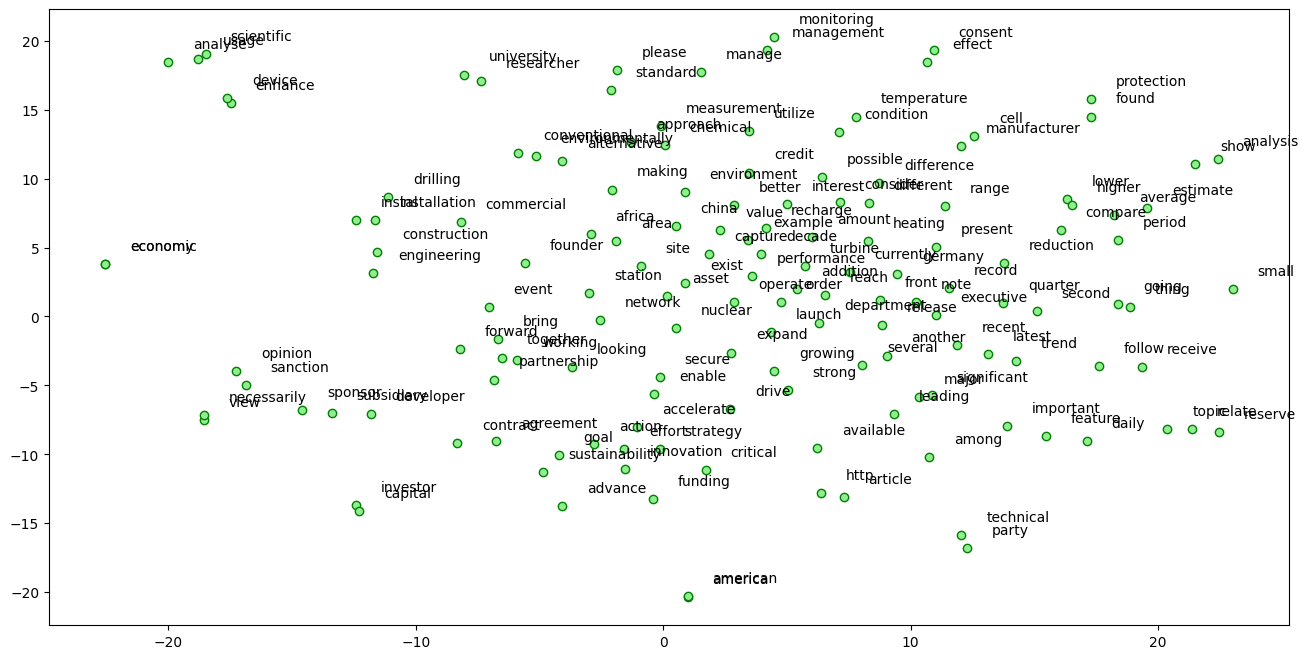

In [ ]:
#using w2v model 3
import numpy as np
from sklearn.manifold import TSNE

words = w2vmodel3.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel3.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Mapping all embeddings in one visualization, it becomes apparent that no strong clusters formed among the words within this model.

In [ ]:
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):

    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=100)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

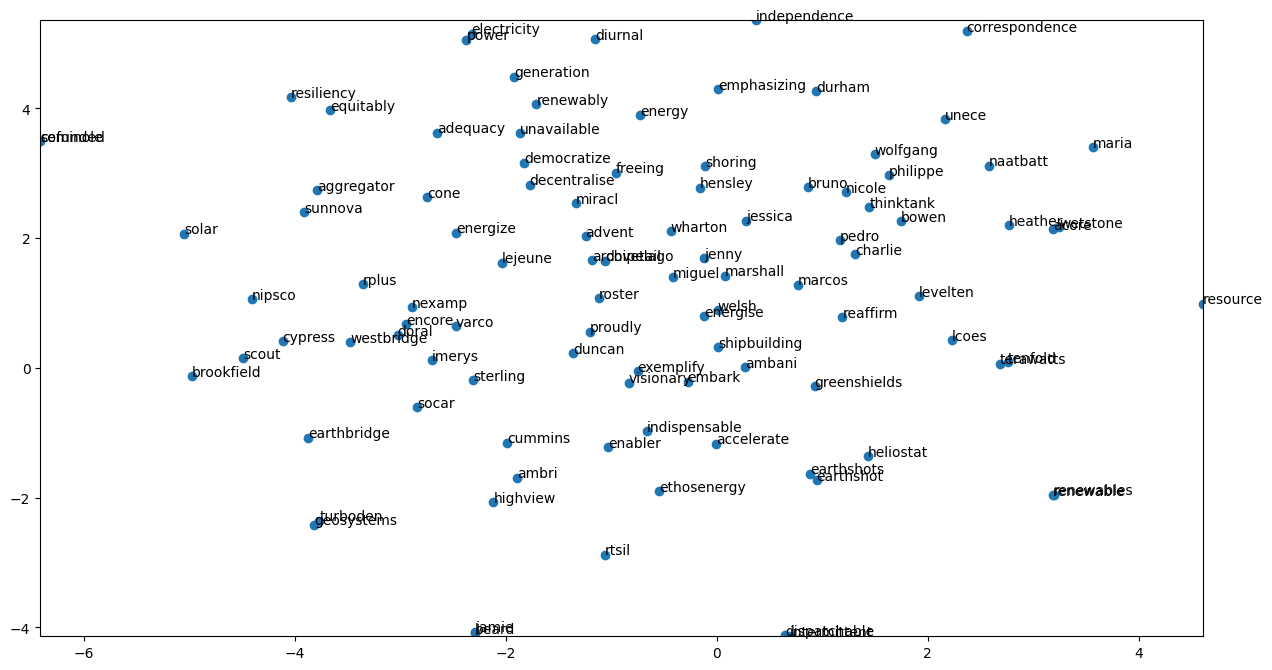

In [ ]:
display_closestwords_tsnescatterplot(w2vmodel3, 'energy', 150)

Taking a closer look at the embedding of the word "energy" and its 100 closest words, we can see line-like structures that hint to a special relationship between those words.

###### 2.4.2 Visualization FastText

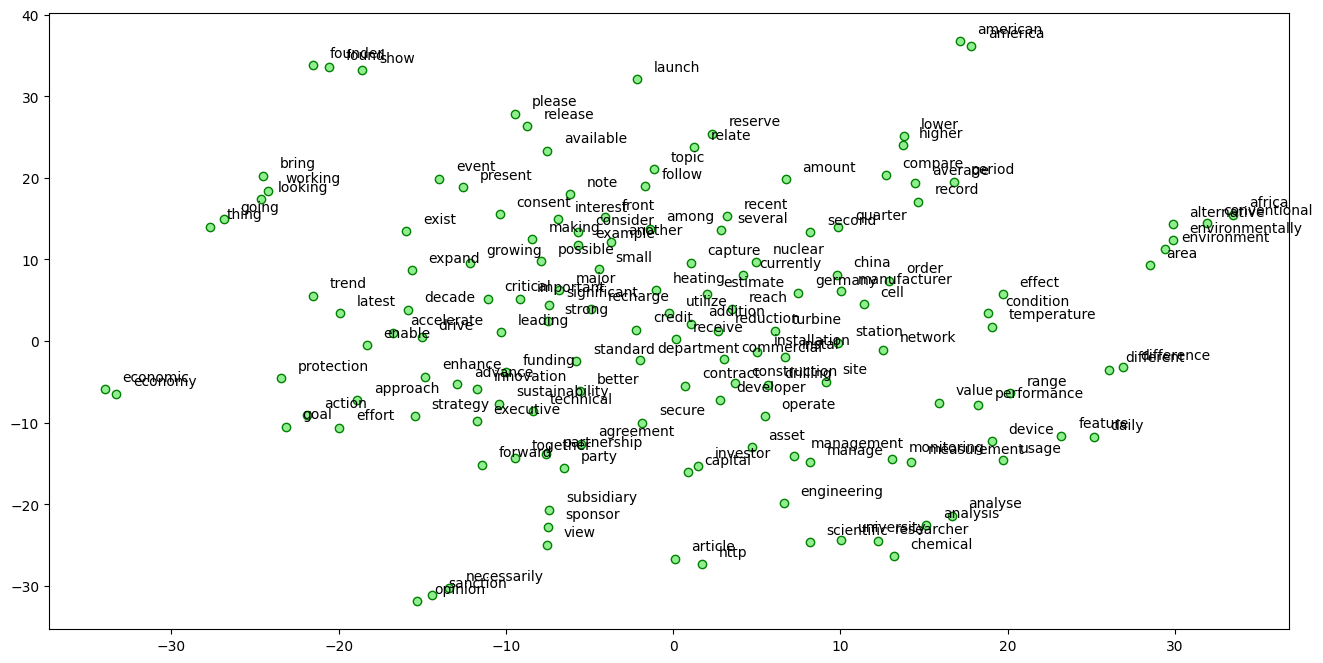

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

words = ftext3.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = ftext3.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Looking at the FastText model, we can see a larger mass in the center. However, there are also several smaller clusters further outside.

In [ ]:
#the same function as in word2vec, can delete here
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):

    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=100)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

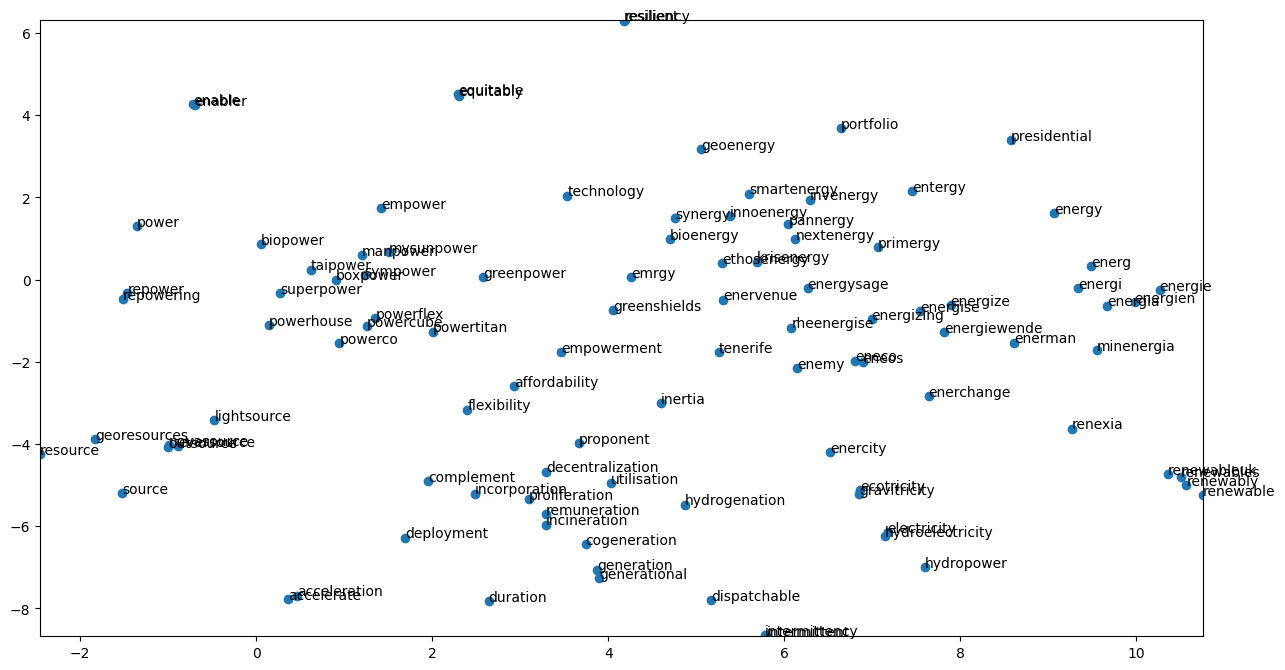

In [ ]:
display_closestwords_tsnescatterplot(ftext3, 'energy', 150)

Similar to the Word2Vec model, when taking a closer look at the word "energy", we can detect line-like structures across the visualization. This, again, can possibly hint at special relationships between the words.

###### 2.4.1 Visualization GloVe

In [ ]:
#transform to keyedvectors
from gensim.models import KeyedVectors
glove_model = KeyedVectors(vector_size=glove.no_components)
for word, index in corpus.dictionary.items():
    glove_model.add_vector(word, glove.word_vectors[index])

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


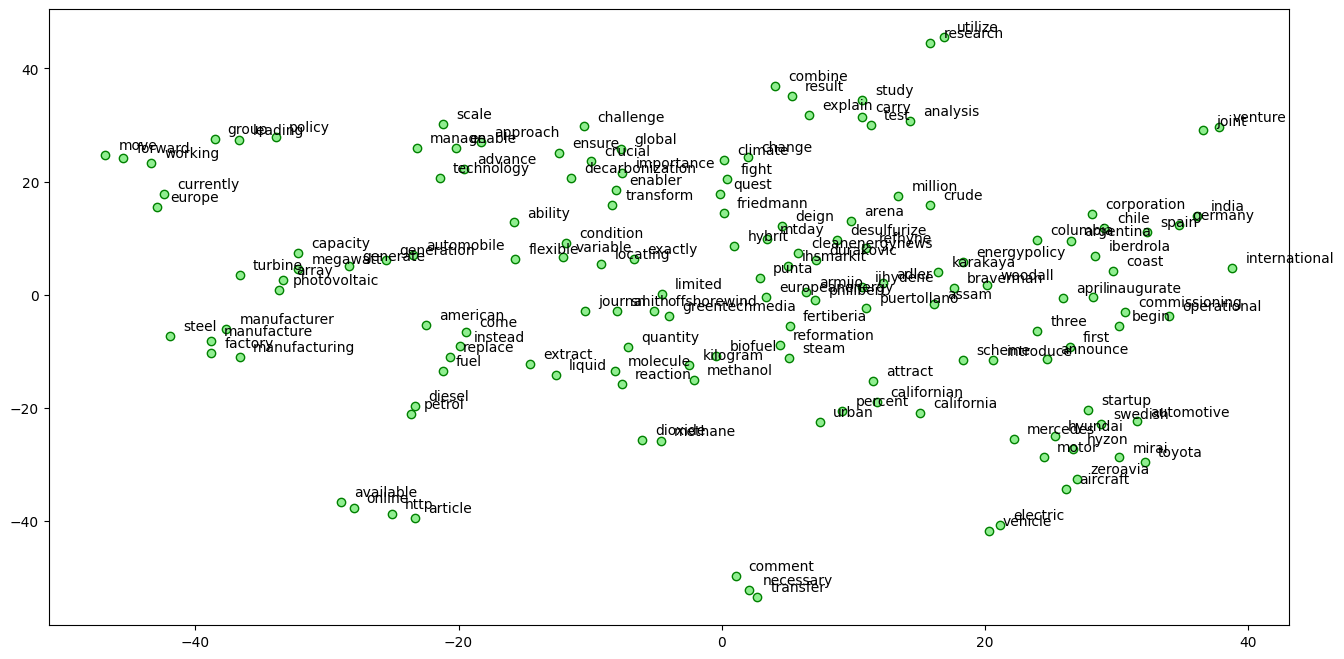

In [ ]:
#visualize GloVe
import numpy as np
from sklearn.manifold import TSNE

words = glove_model.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = glove_model[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Visualizing the GloVe model, we can see a strong pattern of small clusters across the whole map. Compared to Word2Vec and FastText, the GloVe model has the strongest cluster pattern. It gives a more structured impression of the embeddings.

In [ ]:
#specific for GloVe
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):

    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.most_similar(word, topn=100)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

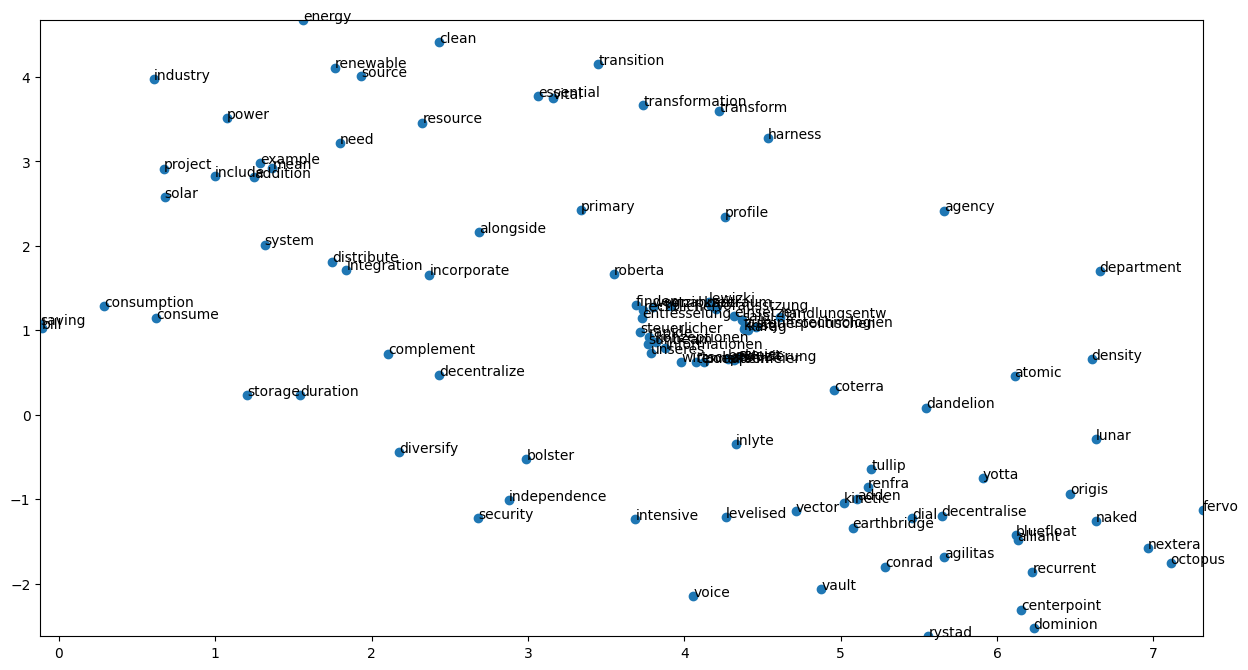

In [ ]:
display_closestwords_tsnescatterplot(glove_model, 'energy', 100)

The visualization of the 100 closest embeddings of the "energy" word embedding shows a strong cluster in the center of the map. The other models don't show a very strong connection unlike here. Also, we can see faint line-like shapes around the large cluster in the middle.

Concluding the explorative analysis of word embedding models, we can say that the Word2Vec shows the highest performance regarding semantic similarity between words. <br>
On the other side, FastText has shown to define the highest similarities overall, but while giving largely syntactic results. <br>
GloVe displays strong patterns in its' visualizations. However, the closest, most similar words defined by the model are either words that appear often together or seem rather ambiguous which leads to results that are hardly human-understandable.

#### 3. Sentence Embedding Training

Sentence embedding is used to capture the meaning and context of a sentence, and can be used in tasks such as text classification, sentiment analysis, and text generation. One key difference between word and sentence embedding is the level of granularity at which they operate.

We did the preprocesssing of the given text from the dataset already within chapter 1. However, there is also another way to do the preprocessing as it will be shown with the following code.

In [ ]:
#sentence preprocessing

import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function for text preprocessing
def preprocess_text(text):
    # Tokenize sentences within the article
    sentences = sent_tokenize(text)

    # Initialize stopwords, lemmatizer, and translation table for special characters removal
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    translation_table = str.maketrans('', '', string.punctuation)

    # Process each sentence
    processed_words = []
    for sentence in sentences:
        # Tokenize words within the sentence
        words = word_tokenize(sentence)

        # Remove stopwords, special characters, numbers, and apply lemmatization
        processed = [
            lemmatizer.lemmatize(word.lower())
            for word in words
            if word.lower() not in stop_words and word.isalpha()
        ]

        processed = [word.translate(translation_table) for word in processed]

        processed_words.extend(processed)

    return processed_words

# Apply preprocessing to the article_column
cleantech_con['preprocessed_sentences'] = cleantech_con['content'].apply(preprocess_text)

# Display preprocessed sentences
print(cleantech_con['preprocessed_sentences'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [qatar, petroleum, qp, targeting, aggressive, ...
1       [nuclear, power, india, npcil, synchronized, w...
2       [new, u, president, joe, biden, took, office, ...
3       [slow, pace, japanese, reactor, restarts, cont...
4       [two, new, york, city, largest, pension, fund,...
                              ...                        
9602    [clean, energy, closed, million, revolving, lo...
9603    [renewable, energy, developer, ørsted, deployi...
9604    [north, america, provider, environmental, solu...
9605    [leading, renewable, power, plant, developer, ...
9606    [energy, closed, financing, viking, project, c...
Name: preprocessed_sentences, Length: 9590, dtype: object


This preprocessed sentences/tokenized words can then also be splitted to test and train data again.

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into Training and Testing Data
train_sentence, test_sentence = train_test_split(cleantech_con["preprocessed_sentences"], train_size=0.7, random_state=5)

print("Train x size :", train_sentence.shape)
print("Test x size :", test_sentence.shape)

Train x size : (6713,)
Test x size : (2877,)


##### 3.1 Averaging Word Vectors

Sentence embedding is used to capture the meaning and context of a sentence, and can be used in tasks such as text classification, sentiment analysis, and text generation. One key difference between word and sentence embedding is the level of granularity at which they operate. For the Averaging Word Vectors the average of all word vectors in a sentence is taken to then represent the average meaning of the sentence.

###### 3.1.1 Model 1

In [ ]:
#train Word2Vec model
word2vec_model = Word2Vec(train_text, vector_size=150, window=7, min_count=15, workers=4)

# Function to get the word vector for a given word
def get_word_vector(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        # If the word is not in the vocabulary, return a vector of zeros
        return np.zeros(word2vec_model.vector_size)

# Function to average word vectors for a sentence
def average_word_vectors(sentence):
    vectors = [get_word_vector(word) for word in sentence]
    # Check if there are any non-zero vectors
    non_zero_vectors = [vector for vector in vectors if np.any(vector)]
    if non_zero_vectors:
        return np.mean(non_zero_vectors, axis=0)
    else:
        # If all vectors are zeros, return a vector of zeros
        return np.zeros(word2vec_model.vector_size)

# Create sentence embeddings
sentence_embeddings = [average_word_vectors(sentence) for sentence in train_text]

# Print sentence embeddings
for i, embedding in enumerate(sentence_embeddings):
    print(f"Sentence {i + 1} embedding: {embedding}")

Streaming output truncated to the last 5000 lines.
 -2.20479034e-02 -1.54858619e-01 -3.95391211e-02  1.24323800e-01
 -1.48539037e-01  3.16461086e-01  1.40010610e-01 -1.44102886e-01
 -5.10250568e-01  1.30727431e-02  1.87387317e-01 -2.25288440e-02
  1.22461520e-01  1.87735572e-01 -6.11240387e-01 -1.85180396e-01
  3.77011567e-01 -6.11321986e-01  8.60939547e-02 -3.95563871e-01
  3.45123500e-01  2.95135587e-01 -2.15678215e-01 -3.61752659e-01
 -1.50058359e-01  1.41937062e-01 -1.52811967e-02  4.06465352e-01
 -2.14898407e-01  3.52050439e-02 -1.40823796e-02  2.75432914e-01
 -3.61010551e-01 -1.07791021e-01 -9.65948701e-02 -8.13247785e-02
  3.26084495e-01 -2.92353213e-01  1.55373305e-01  4.90606800e-02
  1.53536141e-01  2.14476556e-01 -1.90553397e-01 -3.26703995e-01
 -2.13481560e-02 -8.89471918e-02 -2.68909961e-01  2.21080422e-01
 -3.89781982e-01 -2.38813739e-03  2.07664594e-01 -3.56179118e-01
 -2.48017572e-02 -1.63620234e-01  1.04233548e-02 -1.44424215e-01
  2.67808348e-01  2.94775456e-01  3.359

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.02777204  0.17503767 -0.27939242  0.31261626  0.5621475   0.37337643
  0.38900417 -0.06756589 -0.41899773  0.48470396 -0.22330187  0.01560895
 -0.10180523  0.19507295  0.41337073 -0.01898855 -0.64018536  0.13783552
  0.10825469 -0.07828278  0.2460889  -0.24310847 -0.22211741  0.12668973]
Sentence 3682 embedding: [-3.46132576e-01  1.86356053e-01 -4.20666039e-01 -3.28214347e-01
 -1.03433684e-01 -2.98844457e-01 -8.23381841e-02  1.81909185e-02
  4.55348074e-01  1.22193217e-01  4.14553970e-01  1.63855955e-01
 -1.05234026e-03  7.87946656e-02 -4.68590081e-01 -3.61898154e-01
 -1.62709251e-01 -4.43984836e-01  1.51150256e-01 -2.63498276e-01
  2.35761821e-01 -1.00792959e-01 -5.03451079e-02 -5.13081811e-03
  1.87873632e-01 -1.32985726e-01 -1.26665220e-01  1.72314480e-01
 -7.19261467e-01 -3.76572788e-01 -1.87191799e-01  3.80249828e-01
  4.74727005e-01  2.64699548e-01  3.72341424e-01  4.39135998e-01
  3.72944713e-01 -4.52127099e-01 -4.24605714e-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  0.08273194 -0.06680925  0.06449313  0.06410003 -0.107035    0.01119144
 -0.0196771  -0.37853143  0.58098155 -0.25716534 -0.14191572 -0.2334099
  0.09548771 -0.30389917 -0.04961139  0.18062904 -0.1968707  -0.3225249
  0.2006784   0.33594126 -0.01001223  0.59125805  0.0875801   0.32291502
  0.7653345  -0.40347514 -0.12114552 -0.24050745 -0.12927842 -0.42419896
  0.14659454  0.05718799 -0.2918237  -0.35645378 -0.07829284  0.25386265
 -0.20178999 -0.09462252 -0.0598851  -0.34097797 -0.6722429   0.04934885
 -0.449789   -0.39129016  0.17297733 -0.21059875  0.5471266   0.62845045
  0.23768859  0.9806597   0.5072668  -0.02631989 -0.5414868  -0.07550734
  0.5235352   0.06475297  0.19066772  0.1362434  -0.4759591  -0.11063325
  0.28145632 -0.12020827 -0.01897525 -0.2796594   0.12802003  0.18918067
 -0.00538539 -0.28200272 -0.30202964  0.28397804 -0.04116376  0.17723353
  0.40291333  0.21341361 -0.17968334  0.3508568  -0.34646872 -0.16361472
 -

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embedding_1 = sentence_embeddings[0]
embedding_2 = sentence_embeddings[1]

# Reshape the embeddings to be 2D arrays
embedding_1 = embedding_1.reshape(1, -1)
embedding_2 = embedding_2.reshape(1, -1)

# Compute cosine similarity
similarity_score = cosine_similarity(embedding_1, embedding_2)[0, 0]

print(f"Cosine Similarity between Sentence 1 and Sentence 2: {similarity_score}")

Cosine Similarity between Sentence 1 and Sentence 2: 0.5583092570304871


With the code above the similarity between two sentences can be determinded. Between sentence embedding 1 and embedding 2 a similarity arounf 55% exists. However, it is difficult to tell how similar the sentences are since we only have the vectorized numbers.

###### 3.1.2 Model 2
The second model has been created with the sentence preprocessed data. Now it will be interesting to see if there is a different result since the text has been tokenized in two different ways. All the other steps are the same as for model one. We already took the Word2Vec model with the most fitting parameters so it won't make sense to change these again.

In [ ]:
#use sentence preprocessed data and train model2
word2vec_model2 = Word2Vec(train_sentence, vector_size=150, window=7, min_count=15, workers=4)

# Function to get the word vector for a given word
def get_word_vector(word):
    try:
        return word2vec_model2.wv[word]
    except KeyError:
        # If the word is not in the vocabulary, return a vector of zeros
        return np.zeros(word2vec_model2.vector_size)

# Function to average word vectors for a sentence
def average_word_vectors(sentence):
    vectors = [get_word_vector(word) for word in sentence]
    # Check if there are any non-zero vectors
    non_zero_vectors = [vector for vector in vectors if np.any(vector)]
    if non_zero_vectors:
        return np.mean(non_zero_vectors, axis=0)
    else:
        # If all vectors are zeros, return a vector of zeros
        return np.zeros(word2vec_model2.vector_size)

# Create sentence embeddings
sentence_embeddings_new = [average_word_vectors(sentence) for sentence in train_sentence]

# Print sentence embeddings
for i, embedding in enumerate(sentence_embeddings):
    print(f"Sentence {i + 1} embedding: {embedding}")

Streaming output truncated to the last 5000 lines.
  3.80618662e-01  4.48537469e-01  2.14909509e-01 -2.44510025e-02
  1.60158928e-02  4.10814404e-01 -4.49150294e-01  2.20335960e-01
 -1.78705573e-01 -1.92473024e-01 -3.40010747e-02 -2.04913422e-01
  4.44026798e-01  4.06634092e-01  1.35732964e-01 -1.08183600e-01
  6.91917539e-02 -5.27603328e-01 -2.92082816e-01  5.77210188e-01
 -6.17164969e-01 -5.64737737e-01  9.27674547e-02  2.27943346e-01
  4.12087888e-01 -1.09974399e-01 -9.55169946e-02 -4.97868806e-02
  4.43361729e-01 -2.54064590e-01  1.00247361e-01 -4.38822061e-02
 -3.72101337e-01 -1.19271696e-01  4.12199378e-01 -1.51121110e-01
 -6.54066563e-01 -1.31809682e-01 -2.85548002e-01 -3.16705704e-01
  6.54261261e-02  3.18208098e-01 -8.40568263e-03 -1.77635103e-01
 -3.94734681e-01 -1.40128106e-01 -4.36661504e-02 -4.22410309e-01
 -2.28615478e-01  2.56215427e-02  1.72038779e-01  3.77680153e-01
 -1.98072065e-02  1.68651059e-01  3.71802896e-01 -1.92823574e-01
 -7.62793958e-01  1.31101027e-01  1.515

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -0.1641461   0.17324089 -0.36959228 -0.5548809  -0.19345562 -0.05597539
  0.23750176  0.0207152  -0.22048284  0.30549854  0.41665164  0.22232012
 -0.1760428  -0.19424199 -0.28815544 -0.07062862 -0.3840511   0.19358514
 -0.12457245  0.20675813  0.14595307 -0.2528872  -0.09989242 -0.11791123
 -0.16502973  0.14047813 -0.00875432 -0.11668339 -0.12908235 -0.24163683
 -0.20971563 -0.4584929  -0.06793848 -0.02118133 -0.04035563  0.05757705
 -0.38954994  0.25209567 -0.25087902 -0.5513279  -0.3297947  -0.12537546
  0.18615578 -0.48982432  0.13366735  0.1175236   0.25312543  0.13566753
 -0.2810607   0.03961695 -0.14436942  0.24087982 -0.3564729  -0.06581262
  0.10081206  0.08301693 -0.27305594  0.39013895 -0.06609248  0.19246785
  0.6643321  -0.64482397  0.08432406 -0.4616982  -0.25961474 -0.02017485
 -0.557086   -0.4644277  -0.4127186  -0.01773192  0.25166512  0.586941
  0.0322036   0.08800085 -0.13721414 -0.406015   -0.08944181 -0.2817775
 -0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  6.31855875e-02  1.65278658e-01  3.13696474e-01  2.12325409e-01
  2.50753462e-01  9.51429307e-02  1.82509050e-01 -3.69848125e-02
 -6.39529675e-02 -1.58470497e-01 -2.84751188e-02 -1.17593352e-02
 -1.95486635e-01  7.26625845e-02  1.91875204e-01  4.45981383e-01
 -3.22238207e-01 -1.58899382e-01 -5.34381121e-02 -1.12196840e-01
  1.68088958e-01 -1.98424552e-02 -1.18664943e-01 -1.88190058e-01
 -2.15911970e-01  1.43740416e-01  1.16968609e-01  2.55120963e-01
 -1.24529809e-01  3.94633189e-02 -1.11503698e-01  3.50733638e-01
 -1.95349202e-01  2.05093492e-02 -4.22183722e-01 -1.88374311e-01
 -1.31316170e-01 -4.31682646e-01  2.81618200e-02 -5.70418239e-02
  4.76472408e-01 -1.60920918e-01 -1.50304809e-01  6.20064996e-02
 -1.70899808e-01  1.30973076e-02 -3.89458728e-03 -4.04853672e-02
 -2.05058843e-01  4.05301806e-04 -8.83008987e-02  6.85366839e-02
 -8.42248499e-02  3.05084195e-02 -1.94420964e-01  6.23541355e-01
  3.83840919e-01 -6.76458299e-01  1.336

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embedding_1_new = sentence_embeddings_new[0]
embedding_2_new = sentence_embeddings_new[1]

# Reshape the embeddings to be 2D arrays
embedding_1_new = embedding_1_new.reshape(1, -1)
embedding_2_new = embedding_2_new.reshape(1, -1)

# Compute cosine similarity
similarity_score2 = cosine_similarity(embedding_1_new, embedding_2_new)[0, 0]

print(f"Cosine Similarity between Sentence 1 and Sentence 2: {similarity_score2}")

Cosine Similarity between Sentence 1 and Sentence 2: 0.5155962109565735


The cosine similarity between sentence 1 and 2 is a little lower than above. But it still is relatively close to eachother.

##### 3.2. Doc2Vec


The idea of doc2vec is to create a numeric representation of a document, regardless of its length. It does not take it down to words as the Word2Vec.

In [ ]:
train_text_df = pd.DataFrame(train_text)
train_text_df

tokenized
983   [land, build, power, north, platform, offshore...
3041  [green, hydrogen, power, future, click, allow,...
6793  [chubu, participate, eavor, project, geretsrie...
5037  [nextera, team, fuel, minnesota, project, natu...
4024  [business, opportunity, asian, smart, grid, na...
...                                                 ...
7302  [longi, achieve, efficiency, gallium, dope, he...
3059  [cleantech, insight, industry, series, click, ...
4092  [system, quote, address, contact, click, allow...
2267  [normal, wildfire, change, climate, several, y...
2928  [using, industrial, internet, thing, pollution...

[6713 rows x 1 columns]

To train the Doc2Vec model the documents need to be tagged first, so that each document can be treated as an individual:

In [ ]:
#create tagged documents for the model
from gensim.models.doc2vec import TaggedDocument
tagged_train_data = [TaggedDocument(words=words, tags=[str(idx)]) for idx, words in zip(train_text_df.index, train_text_df.tokenized)]

###### 3.2.1. Model 1

In [ ]:
from gensim.models import Doc2Vec

# Training the Doc2Vec model
d2v_model = Doc2Vec(
    vector_size=100,  # Size of the document vectors
    min_count=5,  # Ignore words with a frequency less than 5
    epochs=20  # Number of iterations over the corpus
)

d2v_model.build_vocab(tagged_train_data)  # Build the vocabulary
d2v_model.train(tagged_train_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)  # Train the model

In [ ]:
d2v_model.save("d2v_v100_e20.model") #save the model

After training and saving the model it is also possible to search for the most similar words to specified one.

In [ ]:
#most similar words to "energy"
d2v_model.wv.most_similar("energy")

[('electricity', 0.5420017838478088),
 ('power', 0.46371743083000183),
 ('desnz', 0.43132179975509644),
 ('acore', 0.3869587481021881),
 ('brookfield', 0.3855965733528137),
 ('varga', 0.371081680059433),
 ('intermittent', 0.35881391167640686),
 ('cyclotron', 0.35778388381004333),
 ('hasten', 0.3552667796611786),
 ('sharma', 0.3463382422924042)]

In [ ]:
#most similar words to "solar"
d2v_model.wv.most_similar("solar")

[('photovoltaic', 0.5610229969024658),
 ('renewable', 0.4985203146934509),
 ('bifacial', 0.4749341607093811),
 ('renewables', 0.44705450534820557),
 ('standalone', 0.4353386461734772),
 ('clean', 0.4107588529586792),
 ('vertex', 0.40933477878570557),
 ('solstice', 0.4028211534023285),
 ('agrivoltaics', 0.3952106833457947),
 ('facial', 0.38719606399536133)]

The most similar word to "energy" has a similarity of 54% and the most similar word to "solar" has a similarity of 56%. If we compare this to the results from the word embeddings this seems like a mediocore result. The most similar words are words that a human would also state as similar to the given words.

In [ ]:
# Finding the most similar documents
query_doc = train_text_df.tokenized[1385] #enter an index of train_text
vector = d2v_model.infer_vector(query_doc)
similar_doc = d2v_model.dv.most_similar([vector], topn = 10)

print("Articles similar to: " ,cleantech_con["title"][1385]) #enter an index of train_text
for x in range(10): #match to topn
  simdoc_index = int(similar_doc[x][0])
  print(x+1,".", cleantech_con.title[simdoc_index] ,"\n",cleantech_con.content[simdoc_index])
  print("\n")

Articles similar to:  The Inflation Reduction Act Adds Agricultural Nature-Based Solutions To The Climate Toolkit
1 . The Inflation Reduction Act Adds Agricultural Nature-Based Solutions To The Climate Toolkit 
 ['The USDA is now transforming the US food system toward more resilient local and regional food production, fairer markets for all producers, access to nutritious food in all communities, and building new markets and streams of income for farmers and producers.', 'The largest-ever US investment to fight climate change was signed into law this week. The Inflation Reduction Act ( IRA) is designed to enable the US to significantly reduce greenhouse gas ( GHG) emissions by 40% below 2005 levels by 2030. Interestingly, the IRA bestows significant nature-based funding solutions to support climate-smart agriculture.', 'The money designated in the IRA for agricultural smart-climate solutions incorporates about $ 19.5 billion for agricultural conservation and $ 5 billion for forest mana

With Doc2Vec it is also possible to search for the most similar documents. The top 10 most similar words are shown above. When looking at it there is not much similarity in the sentences, except in the part in squared brackets.

###### 3.2.2. Model 2

For model 2 we have doubled the vector sizes, increased the minimum count and cut down the epochs by 5.

In [ ]:
# Training the Doc2Vec model
d2v_model2 = Doc2Vec(
    vector_size=200,  # Size of the document vectors
    min_count=10,  # Ignore words with a frequency less than 10
    epochs=15  # Number of iterations over the corpus
)

d2v_model2.build_vocab(tagged_train_data)  # Build the vocabulary
d2v_model2.train(tagged_train_data, total_examples=d2v_model2.corpus_count, epochs=d2v_model2.epochs)  # Train the model

In [ ]:
d2v_model2.save("d2v_v200_e15.model") #save the model

In [ ]:
#most similar words to "energy"
d2v_model2.wv.most_similar("energy")

[('power', 0.41082093119621277),
 ('electricity', 0.33577314019203186),
 ('brookfield', 0.2989758551120758),
 ('acore', 0.2831971347332001),
 ('technology', 0.28047120571136475),
 ('defense', 0.27765411138534546),
 ('intermittency', 0.2765043377876282),
 ('emphasizing', 0.2746076285839081),
 ('dispatchable', 0.2714589536190033),
 ('nelnet', 0.2669179141521454)]

In [ ]:
#most similar words to "solar"
d2v_model2.wv.most_similar("solar")

[('photovoltaic', 0.5215157270431519),
 ('bifacial', 0.3907823860645294),
 ('agrivoltaics', 0.3764305114746094),
 ('standalone', 0.3748685121536255),
 ('rooftop', 0.346740186214447),
 ('renewable', 0.34498852491378784),
 ('agrivoltaic', 0.3443197011947632),
 ('residential', 0.3389064371585846),
 ('intergovernmental', 0.33285394310951233),
 ('installing', 0.3279692530632019)]

In [ ]:
# Finding the most similar documents
query_doc = train_text_df.tokenized[1385] #enter an index of train_text
vector = d2v_model2.infer_vector(query_doc)
similar_doc = d2v_model2.dv.most_similar([vector], topn = 10)

print("Articles similar to: " ,cleantech_con["title"][1385]) #enter an index of train_text
for x in range(10): #match to topn
  simdoc_index = int(similar_doc[x][0])
  print(x+1,".", cleantech_con.title[simdoc_index] ,"\n",cleantech_con.content[simdoc_index])
  print("\n")

Articles similar to:  The Inflation Reduction Act Adds Agricultural Nature-Based Solutions To The Climate Toolkit
1 . The Inflation Reduction Act Adds Agricultural Nature-Based Solutions To The Climate Toolkit 
 ['The USDA is now transforming the US food system toward more resilient local and regional food production, fairer markets for all producers, access to nutritious food in all communities, and building new markets and streams of income for farmers and producers.', 'The largest-ever US investment to fight climate change was signed into law this week. The Inflation Reduction Act ( IRA) is designed to enable the US to significantly reduce greenhouse gas ( GHG) emissions by 40% below 2005 levels by 2030. Interestingly, the IRA bestows significant nature-based funding solutions to support climate-smart agriculture.', 'The money designated in the IRA for agricultural smart-climate solutions incorporates about $ 19.5 billion for agricultural conservation and $ 5 billion for forest mana

We can see that the second model with the doubled vector size, 15 epochs and minimum word count of 10 shows much lower similarity scores compared to the first model.
This indicates that the dimensionality for this dataset is set too high in the second model possibly resulting to overfitting. As high-dimensional embeddings capture more specific nuances or noise from the training data, it can cause a decrease in the quality of learned representations for certain words.
Therefore, it can be said that model 1 is more suitable for the cleantech data.




##### 3.4 Sentence Embedding Evaluation

###### 3.4.1 Visualization Averaging Word Vectors

We created two models for the Averaging Word Vectors. Here for each sentence (truncated to 5000) the similarity between the two models is shown. 1 would mean very similar and 0 not similar whereas -1 means totally oposite. It becomes apparent with these results that the embeddings from both models are not too similar.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


# Calculate cosine similarity between corresponding sentence embeddings
similarities = [cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0, 0]
                for embedding1, embedding2 in zip(sentence_embeddings, sentence_embeddings_new)]

# Print or use the similarity values as needed
for i, similarity in enumerate(similarities):
    print(f"Sentence {i + 1} similarity: {similarity}")

This gives the impression that the visualisation of both models will be quite different.

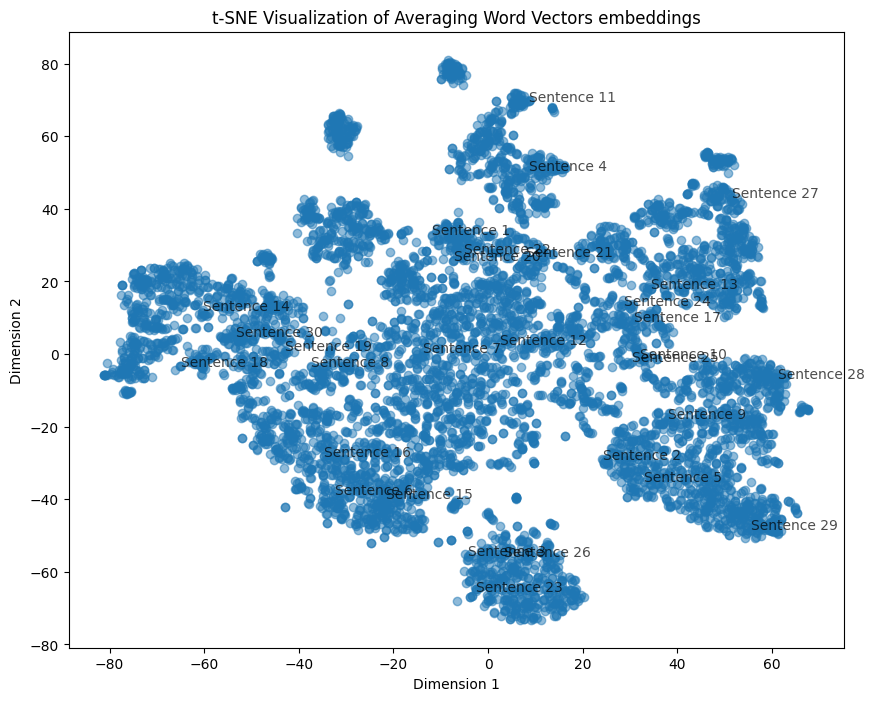

In [ ]:
#Visualize the embeddings of first model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# Convert the list to a NumPy array
sentence_embeddings_np = np.array(sentence_embeddings)

# Apply t-SNE for dimensionality reduction for Averaging Word Vectors
tsne_avg_word_vectors = TSNE(n_components=2, random_state=42)
embeddings_2d_avg_word_vectors = tsne_avg_word_vectors.fit_transform(sentence_embeddings_np)

# Visualize Averaging Word Vectors embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_avg_word_vectors[:, 0], embeddings_2d_avg_word_vectors[:, 1], label='Avg. Word Vectors', alpha=0.5)

# Annotate some points with sentence labels for reference
num_sentences_to_annotate = 30
for i in range(len(sentence_embeddings_np)):
    if i >= num_sentences_to_annotate:
        break
    x, y = embeddings_2d_avg_word_vectors[i]
    plt.annotate(f"Sentence_{i}", (x, y), alpha=0.7)

plt.title('t-SNE Visualization of Averaging Word Vectors embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

Model 1 shows some clusters that are clearly separated from all the other sentences. It also shows some similar sentences close to eachother.

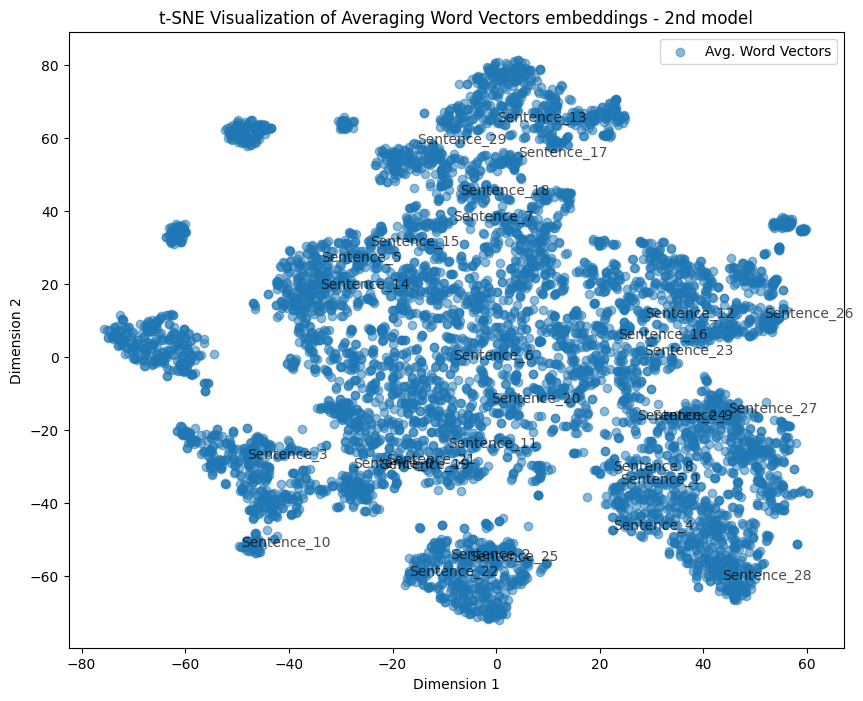

In [ ]:
#visualization of second model

# Convert the list to a NumPy array
sentence_embeddings_np = np.array(sentence_embeddings_new)

# Apply t-SNE for dimensionality reduction for Averaging Word Vectors
tsne_avg_word_vectors = TSNE(n_components=2, random_state=42)
embeddings_2d_avg_word_vectors = tsne_avg_word_vectors.fit_transform(sentence_embeddings_np)

# Visualize Averaging Word Vectors embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_avg_word_vectors[:, 0], embeddings_2d_avg_word_vectors[:, 1], label='Avg. Word Vectors', alpha=0.5)

# Annotate some points with sentence labels for reference
num_sentences_to_annotate = 30
for i in range(len(sentence_embeddings_np)):
    if i >= num_sentences_to_annotate:
        break
    x, y = embeddings_2d_avg_word_vectors[i]
    plt.annotate(f"Sentence_{i}", (x, y), alpha=0.7)

plt.title('t-SNE Visualization of Averaging Word Vectors embeddings - 2nd model')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

Model 2 also includes quite some clusters. It also has a lot of points far away from a sentence number. It looks even more spread than the first model.

###### 3.4.2 Doc2Vec Classifier


In [ ]:
#the train data are be the document vectors of the articles defined in the Doc2Vec model
d2v_train = d2v_model.dv.vectors
d2v_train_label = train_label
d2v_test_label = test_label

In [ ]:
# the vector representations of the test data can be obtained by using .infer_vector()
d2v_test = []
for doc in test_text:
  infer_doc = d2v_model.infer_vector(doc)
  d2v_test.append(infer_doc)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logreg = LogisticRegression(n_jobs=1, C=1e5, solver= "saga", max_iter= 300)
logreg.fit(d2v_train, d2v_train_label)
test_pred = logreg.predict(d2v_test)
print('Testing accuracy for Topic classification %s' % accuracy_score(d2v_test_label, test_pred))
print('Testing F1 score for Topic classification: {}'.format(f1_score(d2v_test_label, test_pred, average='weighted')))

Testing accuracy for Topic classification 0.6656239137990962
Testing F1 score for Topic classification: 0.6650155160273291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can see that out of all the test samples, the model correctly predicted the topic label for around 66.56% of them. <br>
The F1 score for topic classification on the test dataset is approximately 0.67.
The moderate F1 score suggests a reasonable balance between precision and recall across the 15 different labels.

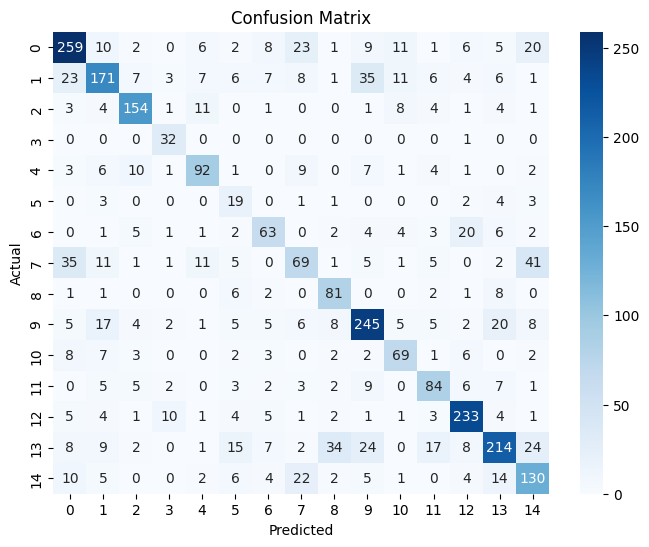

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generating the confusion matrix
conf_matrix = confusion_matrix(d2v_test_label, test_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(d2v_test_label)),
            yticklabels=sorted(set(d2v_test_label)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix reveals that topic 0, 1, 7 and 13 had the highest misclassifications. We can see that Topic 0 was wrongly classified as Topic 7 the most. Topic 1 was often predicted as Topic 9 while Topic 7 holds the highest score with being wrongly classified as Topic 14. On the other side, Topic 3 stands out with only 1 misclassification.

###### 3.4.3 Visualization Doc2Vec

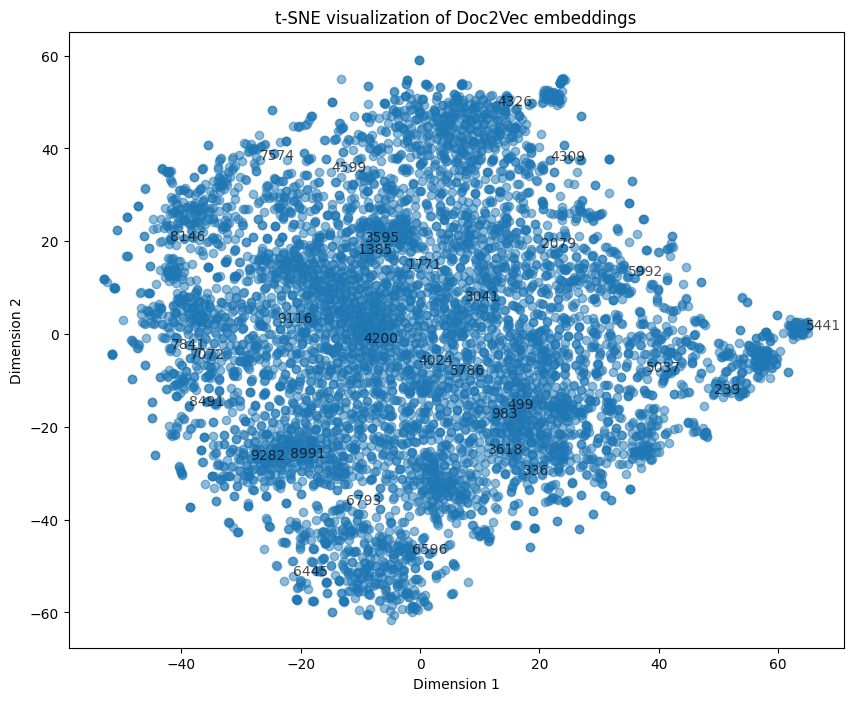

In [ ]:
# Get document vectors and labels
doc_vectors = np.array([d2v_model.dv[i] for i in range(len(d2v_model.dv))])
doc_labels = [tag for tag in train_text_df.index]

# Reduce the dimensionality of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(doc_vectors)

# Visualize the embeddings in a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Annotate some points with document labels for reference
num_docs_to_annotate = 30
for i in range(len(doc_vectors)):
    if i >= num_docs_to_annotate:
        break
    x, y = embeddings_2d[i]
    plt.annotate(doc_labels[i], (x, y), alpha=0.7)

plt.title('t-SNE visualization of Doc2Vec embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
print(cleantech_con.title[7841])
print(cleantech_con.title[7072])
print(cleantech_con.title[9282])
print(cleantech_con.title[8991])

India – pv magazine International
Q2 2021: Workers’ rights – pv magazine International
Sunnova Applies to Develop Solar ‘ Micro-Utility’ Communities in California
174 Power Global, Black Hills Energy Enter PPA to Develop Colorado Solar Facility


The TSNE plot shows the document similarities of the cleantech articles.
Looking at 2 examples, article with index 7841 and 7072 were mapped closely together. The first 2 rows in the above output show the respective article titles. We can see that the articles were published by the same magazine and interpret their close distance in the plot in this way. <br>
Simlarily, articles with index 9282 and 8991 were also mapped closely together. Their article titles reveal a focus on solar facilities which again explains their close semantic relationship displayed in the plot.

Concluding the performance of the sentence embedding models, it can be said that the Doc2Vec model shows a more distributed structure. There are no strong clusters as in the Averaging Word Vectors sentence embedding. It also seems to be a little easier to determine the similarity between words with the Doc2Vec model.

#### 4. Comparison - Open Source Embeddings

In this chapter some pre-trained models are taken and then compared to the performance of our models.

##### 4.1. Word2Vec

###### 4.1.1 Similarities

In [ ]:
#Google's pre-trained model
import gensim.downloader as api
google_vectors = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Compare the similarity scores of 3 closest words of "energy", "solar" and "cleantech":

In [ ]:
google_vectors.most_similar("energy", topn = 3)

[('renewable_energy', 0.6721635460853577),
 ('enery', 0.6289607286453247),
 ('electricity', 0.6030438542366028)]

In [ ]:
w2vmodel3.wv.most_similar("energy", topn = 3)

[('earthbridge', 0.5715175271034241),
 ('power', 0.5565773248672485),
 ('renewable', 0.5551960468292236)]

This shows that both models give different top 3 words that are similar to the word energy. The similarity from the google model is a little more than 60% on average. The Word2Vec model gives a little lower similarity with values around 55%.

In [ ]:
google_vectors.most_similar("solar", topn = 3)

[('photovoltaic', 0.8178172707557678),
 ('solar_PV', 0.802293598651886),
 ('photovoltaic_solar', 0.8008190989494324)]

In [ ]:
w2vmodel3.wv.most_similar("solar", topn = 3)

[('photovoltaic', 0.6631437540054321),
 ('rooftop', 0.5964874029159546),
 ('flexrack', 0.5453980565071106)]

Here is one word even listed by both models. However, the google model has the stronger similarity.

In [ ]:
google_vectors.most_similar("cleantech", topn = 3)

[('greentech', 0.7790235280990601),
 ('Cleantech', 0.7648705840110779),
 ('venture_capital', 0.6916471123695374)]

In [ ]:
w2vmodel3.wv.most_similar("cleantech", topn = 3)

[('ironic', 0.6544201970100403),
 ('laggard', 0.6033338308334351),
 ('india', 0.5244695544242859)]

The last comparison gives quite different words from each model. The percentages are also not as high as before for the google model.

###### 4.1.2 Classifier
In the following, a classifier is implemented to test the performance of our Wor2Vec model. It will be then compared with a classifier built on the pre-trained embeddings.

In [ ]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def document_vector(doc):
    # Remove out-of-vocabulary words and get word vectors
    vectors = [w2vmodel3.wv[word] for word in doc if word in w2vmodel3.wv]

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Calculate the mean of word vectors
    else:
        return np.zeros(w2vmodel3.vector_size)  # Return zeros if no word vectors found

# Create document vectors for training data
w2v_train = np.array([document_vector(doc) for doc in train_text])

# Create document vectors for test data
w2v_test = np.array([document_vector(doc) for doc in test_text])

In [ ]:
#Initialize and train the classifier
logreg = LogisticRegression(n_jobs=1, C=1e5, solver= "saga", max_iter= 300)
logreg.fit(w2v_train, train_label)

# Predict labels for test data
w2v_test_pred = logreg.predict(w2v_test)

# Evaluate the classifier
print('Testing accuracy for Topic classification %s' % accuracy_score(test_label, w2v_test_pred))
print('Testing F1 score for Topic classification: {}'.format(f1_score(test_label, w2v_test_pred, average='weighted')))

Testing accuracy for Topic classification 0.8992005561348627
Testing F1 score for Topic classification: 0.898975131419784


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Achieving nearly 90% accuracy signifies the model's ability to correctly classify topics across the test articles, showing its robust understanding of the underlying semantics. <br>
The F1 score of approximately 0.90 emphasizes a well-balanced performance in precision and recall across the diverse topic labels, indicating a strong overall classification capability.

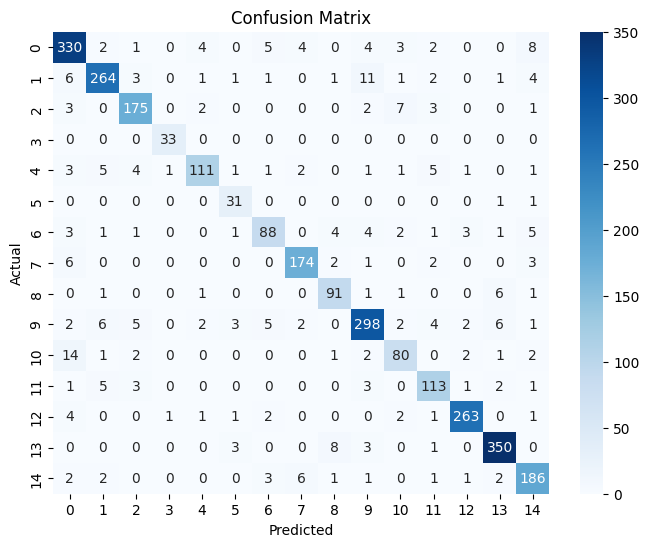

In [ ]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(test_label, w2v_test_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(test_label)),
            yticklabels=sorted(set(test_label)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix consequently shows minimal misclassifications. We can see that Topic 1 was predicted as Topic 9 11 times while Topic 10 was wrongly predicted as Topic 0 14 times.

Now, we will build a classifier with the pre-trained embeddings:

In [ ]:
#the pre-trained embeddings are saved as google_vectors

def document_vector_google(doc):
    # Remove out-of-vocabulary words and get word vectors
    vectors = [google_vectors[word] for word in doc if word in google_vectors]

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Calculate the mean of word vectors
    else:
        return np.zeros(google_vectors.vector_size)  # Return zeros if no word vectors found

# Create document vectors for training data
google_train = np.array([document_vector_google(doc) for doc in train_text])

# Create document vectors for test data
google_test = np.array([document_vector_google(doc) for doc in test_text])

In [ ]:
#Initialize and train the classifier
logreg = LogisticRegression(n_jobs=1, C=1e5, solver= "saga", max_iter= 300)
logreg.fit(google_train, train_label)

# Predict labels for test data
google_test_pred = logreg.predict(google_test)

# Evaluate the classifier
print('Testing accuracy for Topic classification %s' % accuracy_score(test_label, google_test_pred))
print('Testing F1 score for Topic classification: {}'.format(f1_score(test_label, google_test_pred, average='weighted')))

Testing accuracy for Topic classification 0.8547097671185262
Testing F1 score for Topic classification: 0.8541154176965121


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Reporting an accuracy of around 85.47% and an F1 score of approximately 0.85, the pre-trained Google Word2Vec vectors shows good performance in topic classification. <br>
While slightly lower in accuracy compared to our own Word2Vec classifier, the pre-trained Google vectors still demonstrate solid capabilities in accurately identifying and distinguishing among the different topics.

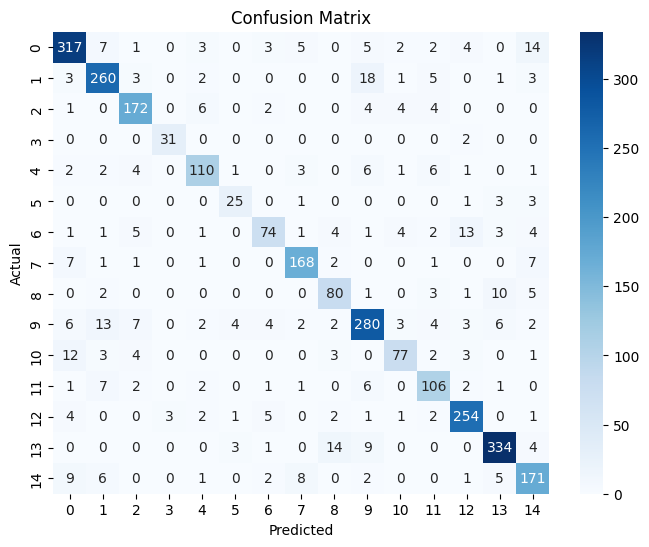

In [ ]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(test_label, google_test_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(test_label)),
            yticklabels=sorted(set(test_label)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix of the Google Word2Vec Classifier shows minor misclassifications. We can see that Topic 1 has been predicted as Topic 9 18 times. Also, Topic 3 stands out with being wrongly predicted only twice.

Both our Word2Vec classifier and the pre-trained Google vectors show good performance in topic classification. While the our model showcases higher accuracy, the pre-trained vectors offer generalizability and broader applicability. Further fine-tuning or implementing domain-specific data could potentially enhance both models' capabilities in semantic understanding and topic classification. Concludingly, it can be said that our own model performs very well regarding the cleantech data, however would presumably lack in performance when used with data that is specific to another domain.

##### 4.2. GloVe

In [ ]:
# Load Wikipedia GloVe vectors
glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


Compare the similarity scores of 3 closest words of "energy", "solar" and "footprint":

In [ ]:
glove_vectors.most_similar("energy", topn = 3)

[('resources', 0.7294265031814575),
 ('gas', 0.7244956493377686),
 ('renewable', 0.7100892663002014)]

In [ ]:
glove.most_similar("energy", number = 4)

[('informationen', 0.6533809397375984),
 ('rapide', 0.6141387930889267),
 ('independence', 0.6120693153991937)]

The pre-trained wikipedia glove model has slightly higher percentages than our trained GloVe model. The similarities for the word "energy" shown by our GloVe model are hardly interpretable in this case.

In [ ]:
glove_vectors.most_similar("solar", topn = 3)

[('photovoltaic', 0.7345330715179443),
 ('geothermal', 0.6855775117874146),
 ('thermal', 0.6832093000411987)]

In [ ]:
glove.most_similar("solar", number = 4)

[('rooftop', 0.6535364014702609),
 ('installing', 0.6430804960830817),
 ('photovoltaic', 0.6285177941144225)]

Interesting to see is again "photovoltaic" that is listed twice. The pre-trained model shows it as more similar than our model.

In [ ]:
glove_vectors.most_similar("footprint", topn = 3)

[('carbon', 0.5296242833137512),
 ('size', 0.514638364315033),
 ('sphere', 0.49827057123184204)]

In [ ]:
glove.most_similar("footprint", number = 4)

[('carbon', 0.7618869559555087),
 ('reducing', 0.7277596072441175),
 ('reduce', 0.6457086066051951)]

For the last comparison the GloVe model we created defines more similar words than the wikipedia model. That seems surprising after everything seen. We can also see the limitations of the GloVe model vocabulary as the open-source model is able to associate "size" with "footprint" which is a justified, human-verifiable word similarity.

The pre-trained embeddings are trained on a large corpus of text, so they mostly have a higher performance than the manually trained embeddings. We can see that their implementation if fairly easy and fast, as they don't need any additional training. <br>
However, therefore, we can also see that they are not always strong at capturing domain-specific nuances. Also, the pre-trained embeddings might contain words that are missing or have different meanings in a specific domain. Out-of-vocabulary (OOV) words might not always have embeddings available.

#### 5. Transfer Learning with pre-trained BERT model

In [ ]:
#assign the articles and labels to pass to the model
articles = cleantech_con.cleaned_text.values
labels = topic_df.topics.values

In [ ]:
from sklearn.model_selection import train_test_split
#perform a train-test split with the assigned topic labels
train_input, val_input, train_label, val_label = train_test_split(articles, labels)

In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [ ]:
#select tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

During our research, we have discovered that there are different versions of BERT available. These differ among each other by the input they are trained on. E.g., there are models which are pre-trained on a specific area like finBERT, which is specifically trained on finance-related publications. However, in the case for cleantech, we are dealing with energy-related articles. At this point there is no such specified BERT model available. Therefore, we will go on with the rather standard version of BERT.

In [ ]:
#find maximum article length
max_len = 0
for article in articles:
  # Update the maximum article length.
  max_len = max(max_len, len(article.split()))
print('Max article length: ', max_len)

#alternative
#cleantech_con.cleaned_text.str.split().str.len().max()

Max article length:  3035


As we can see, the maximum article length in the dataset is 3035 words. However, as it is not possible to pass data longer than 512 tokens to BERT, we have to split the articles into chunks first.<br> <br>
The following function "mask_inputs_for_bert" processes and prepared the cleantech articles to pass it to the model. It <br>
- splits the articles into chunks (512 tokens each), <br>
- adds the start and end tokens "[CLS]” and "[SEP]”,<br>
- pads the chunks smaller than the maximum size with "[PAD]”, <br>
- aligns the topic labels with the increased size of chunks, <br>
- and returns the input, masks and labels in tensor type.  

In [ ]:
def mask_inputs_for_bert(articles, max_len, x_label):
    input_ids = []
    attention_masks = []
    label = []

    for article in articles:
        # Tokenize the article into tokens
        tokens = tokenizer.tokenize(article)

        # Account for special tokens [CLS], [SEP], and [PAD]
        max_chunk_len = max_len - 2
        chunks = [tokens[i:i + max_chunk_len] for i in range(0, len(tokens), max_chunk_len)]

        for _ in range(len(chunks)):
          labelindex = articles.tolist().index(article)
          label.append(x_label[labelindex])

        for chunk in chunks:
            # Add [CLS] and [SEP] tokens and convert to input IDs
            indexed_tokens = tokenizer.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]'])
            input_ids.append(indexed_tokens)

            # Create attention mask
            attn_mask = [1] * len(indexed_tokens)
            attention_masks.append(attn_mask)


    # Pad sequences to ensure they have the same length
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")

    #Convert to tensor
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    label = tf.constant(label)


    return input_ids, attention_masks, label

In [ ]:
# Apply preprocessing:
max_len = 512  # Max length for BERT
train_input_ids, train_attention_masks, train_label = mask_inputs_for_bert(train_input, max_len, train_label)
val_input_ids, val_attention_masks, val_label = mask_inputs_for_bert(val_input, max_len, val_label)

In [ ]:
print("Train_input_shape", train_input_ids.shape)
print("Train_mask_shape", train_attention_masks.shape)
print("Validation_input_shape" ,val_input_ids.shape)
print("Validation_mask_shape", val_attention_masks.shape)
print("Train_label_shape", train_label.shape)
print("Validation_label_shape", val_label.shape)

Train_input_shape (15653, 512)
Train_mask_shape (15653, 512)
Validation_input_shape (5232, 512)
Validation_mask_shape (5232, 512)
Train_label_shape (15653,)
Validation_label_shape (5232,)


We can see that the train and validation input have now a length of 512 tokens. Chunks shorter than this threshold are padded in the preprocessing to match the length.<br>
The topic labels have been aligned with the inputs that have a larger shape due to the split in chunks.

In [ ]:
#introducing the model. There are 15 labels as we have 15 different assigned topics in this dataset
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 15)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
log_dir='/content/drive/MyDrive/CLT Project/NLP Stage 2'
model_save_path='/content/drive/MyDrive/CLT Project/NLP Stage 2/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,\
                                                  save_weights_only=True,\
                                                  monitor='val_loss',\
                                                  mode= 'min',\
                                                  save_best_only=True),\
            keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

bert_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  11535     
                                                                 
Total params: 109493775 (417.69 MB)
Trainable params: 109493775 (417.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bert Model None


In [ ]:
history=bert_model.fit([train_input_ids, train_attention_masks],\
                       train_label,\
                       batch_size=8,\
                       epochs=1,\
                       validation_data=([val_input_ids, val_attention_masks],val_label),\
                       callbacks=callbacks)

 258/1965 [==>...........................] - ETA: 28:39:56 - loss: 2.0019 - accuracy: 0.4462

The process of fine-tuning the open-source model included several steps by preparing the data to align it with the input specifications of the BERT model. As visible above, the fitting process of the model is very heavy on the resources and time consuming. Unfortunately, the available RAM on Google Colab could not support the fitting with larger batch sizes such as 16 or 32. Running the process at the displayed batch size of 8 unfortunately exceeds the maximum runtime set by Colab. However, the process bar above reveals that just after approx. 15% of the fitting, the model could already reach an accuracy of approx 45%. At this point, promising results could have aleady been considered.<br> <br>
In an optimal environment, the batch size should be increased to speed up the process while it would be sensible to increase the epochs to at least 4.